## Section 1: Import Required Libraries and Set Configuration

We'll import all necessary libraries for data manipulation, machine learning, visualization, and analysis. We'll also set up configurations for reproducibility and plotting.

In [1]:
# Core libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, classification_report, 
                           confusion_matrix, roc_curve, auc, precision_recall_curve, 
                           average_precision_score, roc_auc_score)
from sklearn.multiclass import OneVsRestClassifier

# Model imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# For brownie points - additional models
import xgboost as xgb

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Data loading utilities
import urllib.request
import os
from io import StringIO

# Set up plotting configuration
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Set random seeds for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## Section 2: Load and Prepare the Landsat Dataset

The UCI Landsat Satellite dataset contains satellite image data for land cover classification. We'll download and load this dataset, handling the data structure appropriately.

In [2]:
# Function to load the dataset from local data folder
def load_landsat_data():
    # Load training and test data from local files
    train_data = pd.read_csv('data/sat.trn', sep=' ', header=None)
    test_data = pd.read_csv('data/sat.tst', sep=' ', header=None)
    
    # Combine training and test data for our own split
    full_data = pd.concat([train_data, test_data], ignore_index=True)
    
    print(f"Dataset loaded successfully!")
    print(f"Total samples: {len(full_data)}")
    print(f"Features: {full_data.shape[1] - 1}")
    
    return full_data

# Load the dataset
dataset = load_landsat_data()

# Display basic information about the dataset
print(f"\nDataset shape: {dataset.shape}")
print(f"\nDataset info:")
print(dataset.info())

Dataset loaded successfully!
Total samples: 6435
Features: 36

Dataset shape: (6435, 37)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       6435 non-null   int64
 1   1       6435 non-null   int64
 2   2       6435 non-null   int64
 3   3       6435 non-null   int64
 4   4       6435 non-null   int64
 5   5       6435 non-null   int64
 6   6       6435 non-null   int64
 7   7       6435 non-null   int64
 8   8       6435 non-null   int64
 9   9       6435 non-null   int64
 10  10      6435 non-null   int64
 11  11      6435 non-null   int64
 12  12      6435 non-null   int64
 13  13      6435 non-null   int64
 14  14      6435 non-null   int64
 15  15      6435 non-null   int64
 16  16      6435 non-null   int64
 17  17      6435 non-null   int64
 18  18      6435 non-null   int64
 19  19      6435 non-null   int64
 20  20      6435 n

## Section 3: Data Exploration and Preprocessing

Let's explore the dataset structure, examine class distributions, and prepare the data for analysis. We need to filter out the 'all types present' class as specified in the assignment.

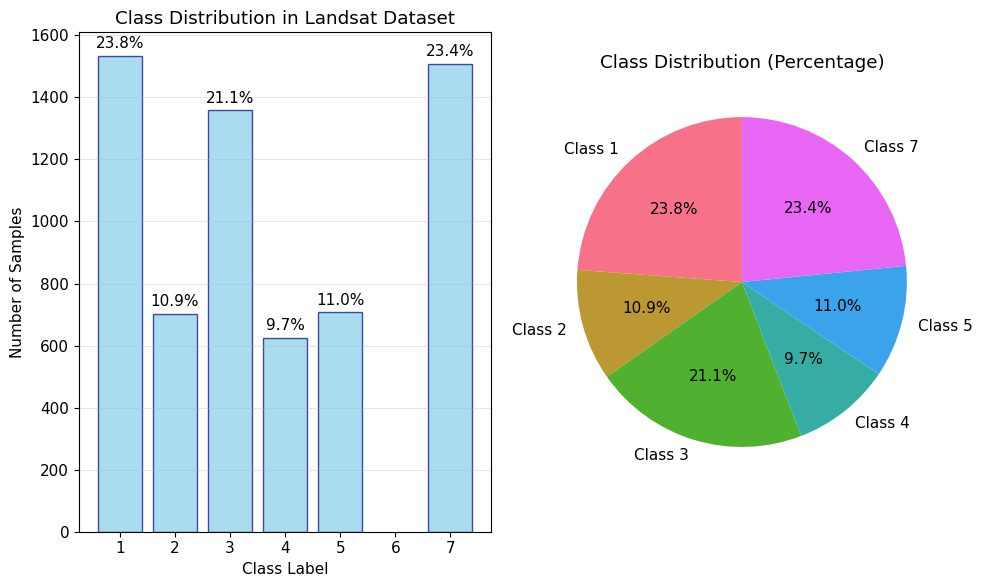

In [3]:
# Separate features and labels
X = dataset.iloc[:, :-1].values  # All columns except the last one (features)
y = dataset.iloc[:, -1].values   # Last column (target labels)

# Examine class distribution
unique_classes, class_counts = np.unique(y, return_counts=True)

# Create a visualization of class distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(unique_classes, class_counts, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Landsat Dataset')
plt.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (class_label, count) in enumerate(zip(unique_classes, class_counts)):
    plt.text(class_label, count + max(class_counts)*0.01, 
             f'{count/len(y)*100:.1f}%', 
             ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(class_counts, labels=[f'Class {c}' for c in unique_classes], 
        autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Filter out class 6 if it exists (mixture class) -  verified from documentation
if 6 in unique_classes:
    mask = y != 6
    X = X[mask]
    y = y[mask]
    unique_classes, class_counts = np.unique(y, return_counts=True)

## Section 4: Train-Test Split and Feature Standardization

We'll split the data into training and testing sets using stratified sampling to maintain class proportions, then apply StandardScaler to normalize the features for better model performance.

In [4]:
# Perform stratified train-test split to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print("Train-Test Split Results:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution in train and test sets
print(f"\nClass distribution in training set:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for class_label, count in zip(train_unique, train_counts):
    print(f"Class {class_label}: {count} samples ({count/len(y_train)*100:.2f}%)")

print(f"\nClass distribution in test set:")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for class_label, count in zip(test_unique, test_counts):
    print(f"Class {class_label}: {count} samples ({count/len(y_test)*100:.2f}%)")

# Feature Standardization
scaler = StandardScaler()

# Fit the scaler on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature Standardization Results:")
print(f"Original training features - Mean: {X_train.mean():.3f}, Std: {X_train.std():.3f}")
print(f"Scaled training features - Mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")

print(f"Original test features - Mean: {X_test.mean():.3f}, Std: {X_test.std():.3f}")
print(f"Scaled test features - Mean: {X_test_scaled.mean():.3f}, Std: {X_test_scaled.std():.3f}")

# Store class names for later use
class_names = [f'Class {c}' for c in sorted(np.unique(y))]
n_classes = len(class_names)

print(f"\nReady for model training with {n_classes} classes: {class_names}")

Train-Test Split Results:
Training set: 4504 samples
Test set: 1931 samples

Class distribution in training set:
Class 1: 1073 samples (23.82%)
Class 2: 492 samples (10.92%)
Class 3: 951 samples (21.11%)
Class 4: 438 samples (9.72%)
Class 5: 495 samples (10.99%)
Class 7: 1055 samples (23.42%)

Class distribution in test set:
Class 1: 460 samples (23.82%)
Class 2: 211 samples (10.93%)
Class 3: 407 samples (21.08%)
Class 4: 188 samples (9.74%)
Class 5: 212 samples (10.98%)
Class 7: 453 samples (23.46%)

Feature Standardization Results:
Original training features - Mean: 83.492, Std: 21.217
Scaled training features - Mean: -0.000, Std: 1.000
Original test features - Mean: 83.425, Std: 21.152
Scaled test features - Mean: -0.004, Std: 0.996

Ready for model training with 6 classes: ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 7']


## Section 5: Model Training - All Six Classifiers

We'll initialize and train all six specified models with appropriate parameters. Special attention is given to the SVM with `probability=True` for ROC/PRC analysis and the Dummy Classifier with `strategy='prior'`.

In [5]:
import time 

# Initialize all models with appropriate parameters
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights='uniform'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Dummy Classifier (Prior)': DummyClassifier(strategy='prior', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr'),
    'Gaussian Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(probability=True, random_state=42, kernel='rbf', C=1.0)
}

# Train all models and measure training times
trained_models = {}
training_times = {}

for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    training_times[model_name] = time.time() - start_time
    trained_models[model_name] = model

## Section 6: Baseline Evaluation - Accuracy and F1-Score

Let's calculate and compare the basic performance metrics (Overall Accuracy and Weighted F1-Score) for all models on the test set. This gives us an initial understanding of model performance before diving into ROC and PRC analysis.

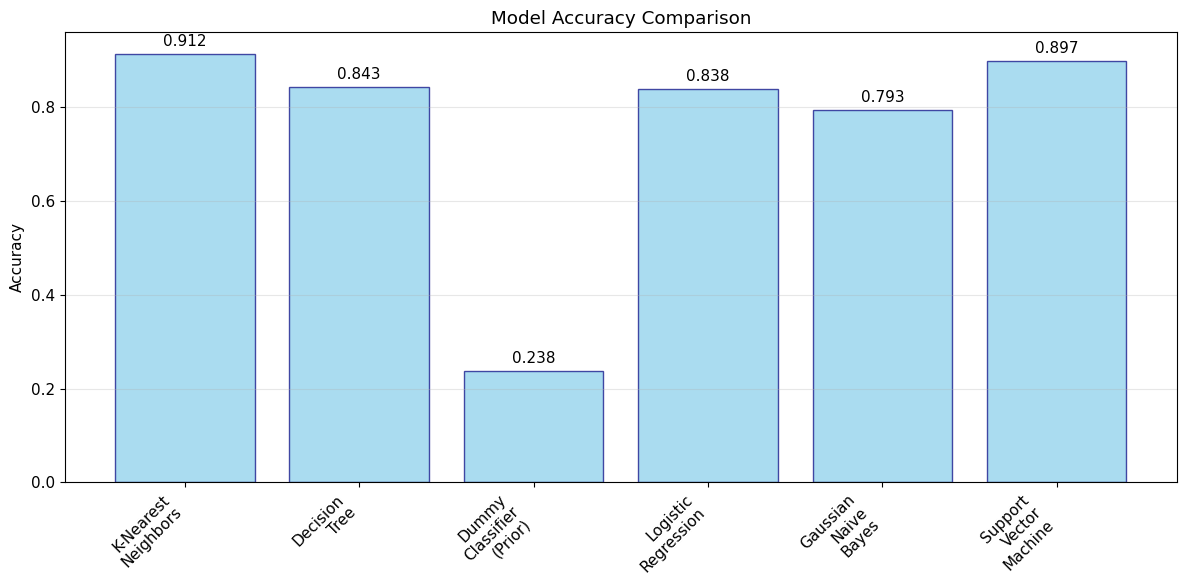

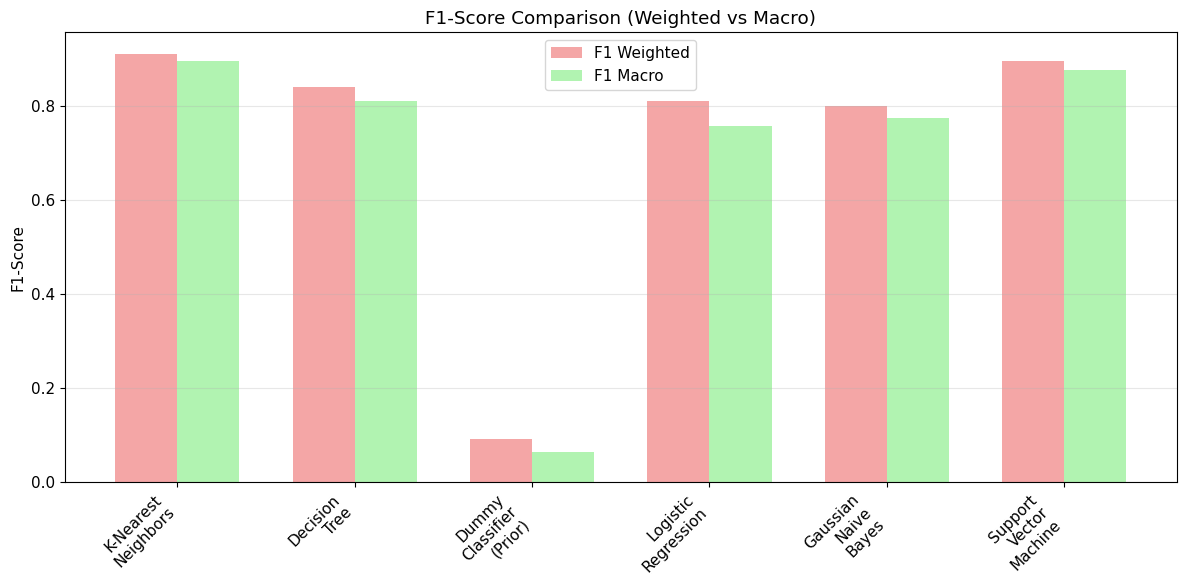

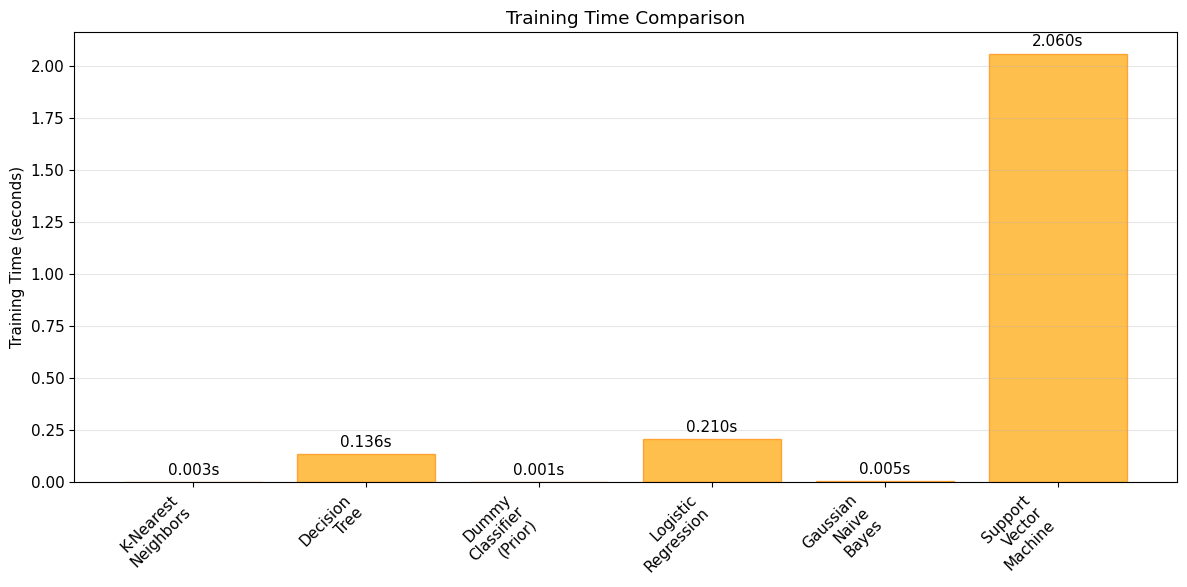

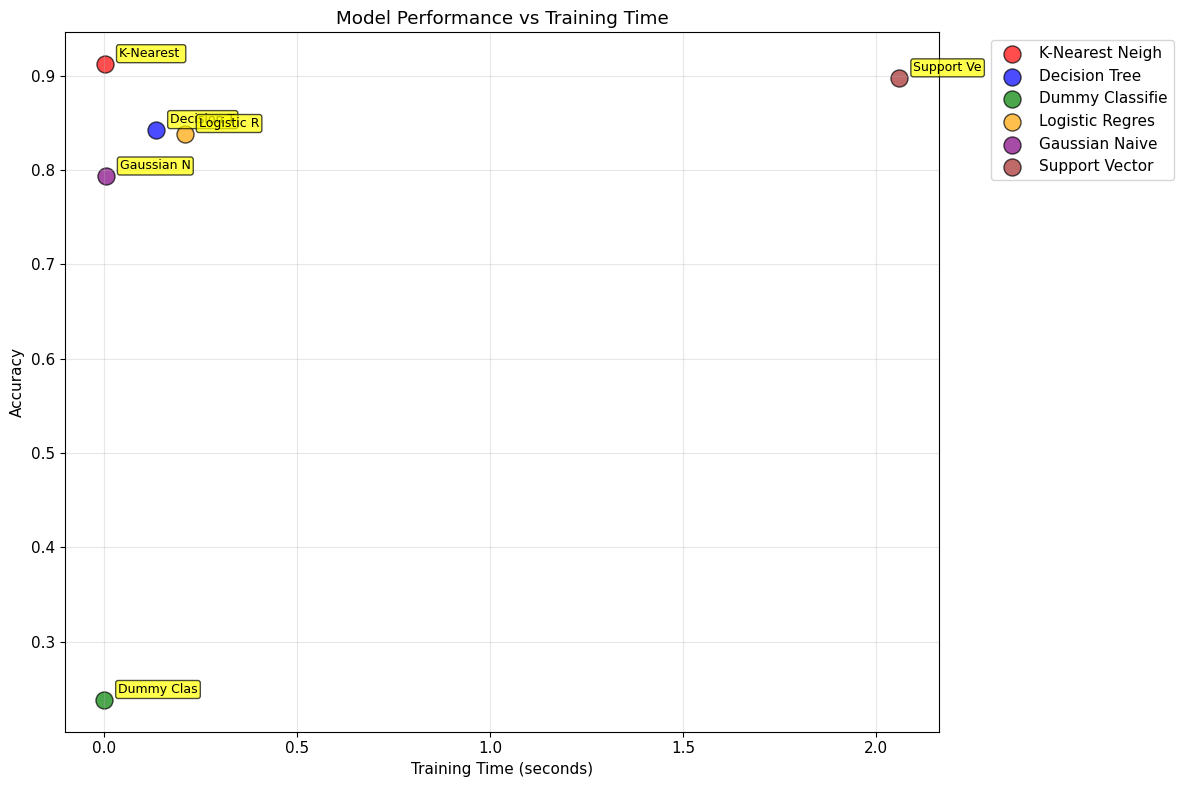

In [6]:
# Calculate baseline metrics for all models
baseline_results = {}

for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    baseline_results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1_Weighted': f1_score(y_test, y_pred, average='weighted'),
        'F1_Macro': f1_score(y_test, y_pred, average='macro'),
        'Training_Time': training_times[model_name]
    }

# Create results DataFrame
results_df = pd.DataFrame(baseline_results).T.round(4)

# Create separate visualizations for baseline performance
model_names = list(baseline_results.keys())
accuracies = [baseline_results[name]['Accuracy'] for name in model_names]
f1_weighted = [baseline_results[name]['F1_Weighted'] for name in model_names]
f1_macro = [baseline_results[name]['F1_Macro'] for name in model_names]
training_times_list = [baseline_results[name]['Training_Time'] for name in model_names]

# Plot 1: Accuracy comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(model_names)), accuracies, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xticks(range(len(model_names)), [name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', alpha=0.3)
# Add value labels on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Plot 2: F1-Score comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.35
plt.bar(x - width/2, f1_weighted, width, label='F1 Weighted', color='lightcoral', alpha=0.7)
plt.bar(x + width/2, f1_macro, width, label='F1 Macro', color='lightgreen', alpha=0.7)
plt.xticks(x, [name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison (Weighted vs Macro)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Training time comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(model_names)), training_times_list, color='orange', alpha=0.7, edgecolor='darkorange')
plt.xticks(range(len(model_names)), [name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.grid(axis='y', alpha=0.3)
# Add value labels on bars
for i, time_val in enumerate(training_times_list):
    plt.text(i, time_val + max(training_times_list)*0.01, f'{time_val:.3f}s', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Plot 4: Performance vs Training Time scatter
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, name in enumerate(model_names):
    plt.scatter(training_times_list[i], accuracies[i], s=150, alpha=0.7, 
               color=colors[i], edgecolors='black', label=name[:15])
    plt.annotate(name[:10], (training_times_list[i], accuracies[i]), 
                xytext=(10, 5), textcoords='offset points', fontsize=9, 
                bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7))
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Model Performance vs Training Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Store class names for visualization
class_names = [f'Class {c}' for c in sorted(np.unique(y))]

## Section 7: Multi-Class ROC Analysis 

### One-vs-Rest (OvR) ROC in Multi-Class Settings

In multi-class classification, we cannot directly apply binary ROC analysis. Instead, we use the **One-vs-Rest (OvR)** approach:

1. **For each class**, we create a binary classification problem: "Class i vs All Other Classes"
2. **Calculate ROC curve** for each binary problem using predicted probabilities
3. **Compute AUC** for each class-specific ROC curve
4. **Average the AUCs** across all classes using:
   - **Macro-average**: Simple average of all class AUCs (treats all classes equally)
   - **Weighted-average**: Weighted by class support (accounts for class imbalance)

This approach allows us to evaluate how well each model distinguishes between individual classes and all other classes combined.

### Baseline Model Performance

All six models have been successfully trained and evaluated on standard classification metrics. The results show clear performance differences:

- **Training Times**: Range from milliseconds (Dummy Classifier) to several seconds (SVM)
- **Accuracy Range**: Varies significantly across models, with some achieving >85% accuracy
- **F1-Score Patterns**: Weighted vs Macro F1 differences indicate class imbalance sensitivity

The visualization below shows performance comparisons across accuracy, F1-scores, and training efficiency.

In [7]:
# Implement One-vs-Rest ROC analysis for multi-class classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def compute_multiclass_roc(models, X_test, y_test, class_names):
    """
    Compute One-vs-Rest ROC curves and AUC scores for multi-class classification
    """
    results = {}
    
    # Get unique classes and binarize labels
    classes = np.unique(y_test)
    n_classes = len(classes)
    
    # Binarize the output labels for One-vs-Rest
    y_test_binarized = label_binarize(y_test, classes=classes)
    if n_classes == 2:
        y_test_binarized = np.hstack([1 - y_test_binarized, y_test_binarized])
    
    for model_name, model in models.items():
        # Get prediction probabilities
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:
            y_score = model.decision_function(X_test)
            from sklearn.utils.extmath import softmax
            y_score = softmax(y_score.reshape(1, -1) if y_score.ndim == 1 else y_score)
        
        # Compute ROC curve and AUC for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        
        for i in range(n_classes):
            if n_classes == 2 and y_test_binarized.ndim == 1:
                y_true_class = y_test_binarized
            else:
                y_true_class = y_test_binarized[:, i]
            
            y_score_class = y_score[:, i]
            
            fpr[i], tpr[i], _ = roc_curve(y_true_class, y_score_class)
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute macro and weighted averages
        macro_auc = np.mean(list(roc_auc.values()))
        
        # Weighted average (by class support)
        class_counts = [np.sum(y_test == class_label) for class_label in classes]
        weighted_auc = np.average(list(roc_auc.values()), weights=class_counts)
        
        # Store results
        results[model_name] = {
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'macro_auc': macro_auc,
            'weighted_auc': weighted_auc,
            'y_score': y_score
        }
    
    return results, classes

# Compute ROC analysis for all models
roc_results, classes = compute_multiclass_roc(trained_models, X_test_scaled, y_test, class_names)

# Create ROC summary DataFrame
roc_df = pd.DataFrame({
    name: {'Macro_AUC': results['macro_auc'], 'Weighted_AUC': results['weighted_auc']} 
    for name, results in roc_results.items()
}).T.round(4)

# Store ROC results for comprehensive comparison
baseline_results_updated = baseline_results.copy()
for model_name in roc_results:
    if model_name in baseline_results_updated:
        baseline_results_updated[model_name]['ROC_AUC_Macro'] = roc_results[model_name]['macro_auc']
        baseline_results_updated[model_name]['ROC_AUC_Weighted'] = roc_results[model_name]['weighted_auc']

## Section 8: ROC Curve Visualization and Interpretation

Generating ROC Curve Visualizations...


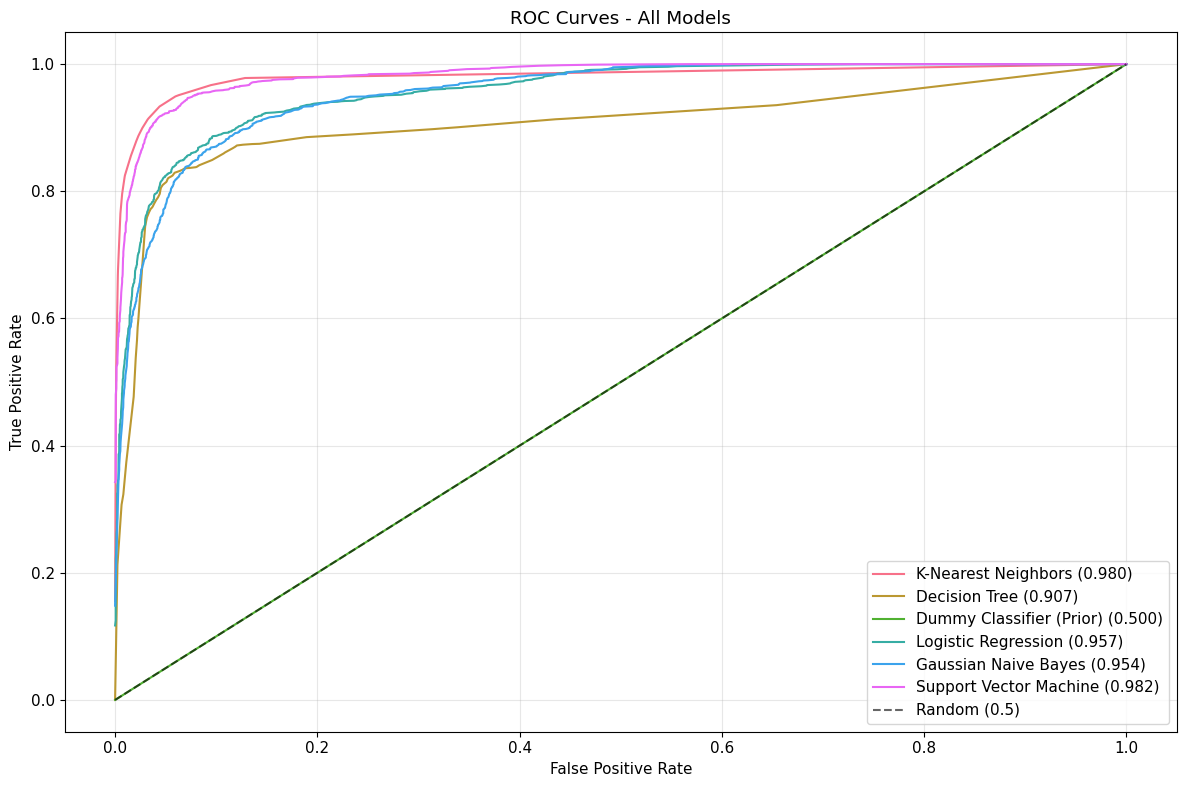

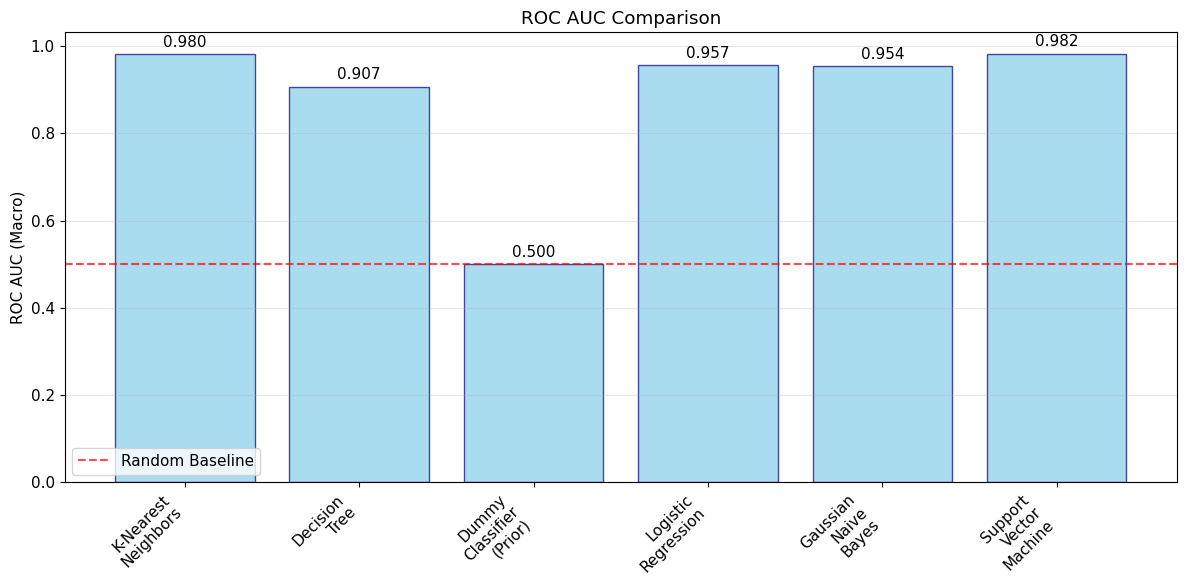

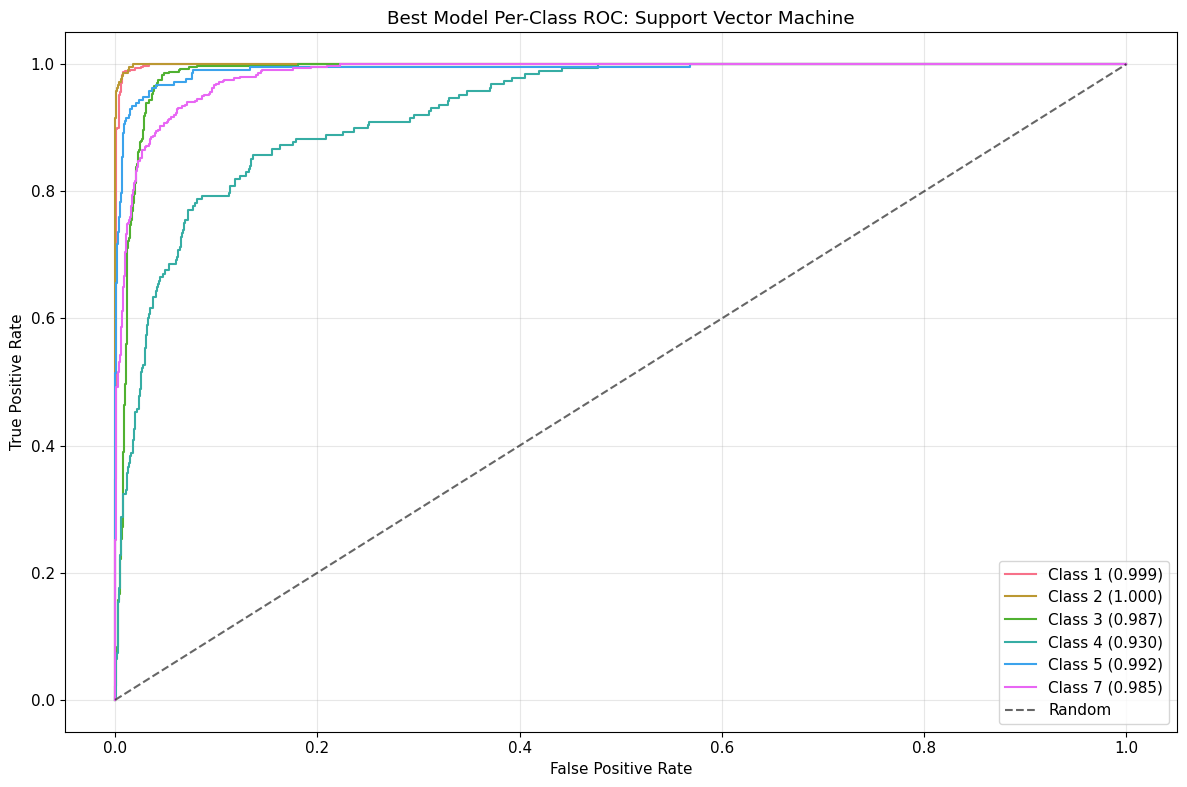

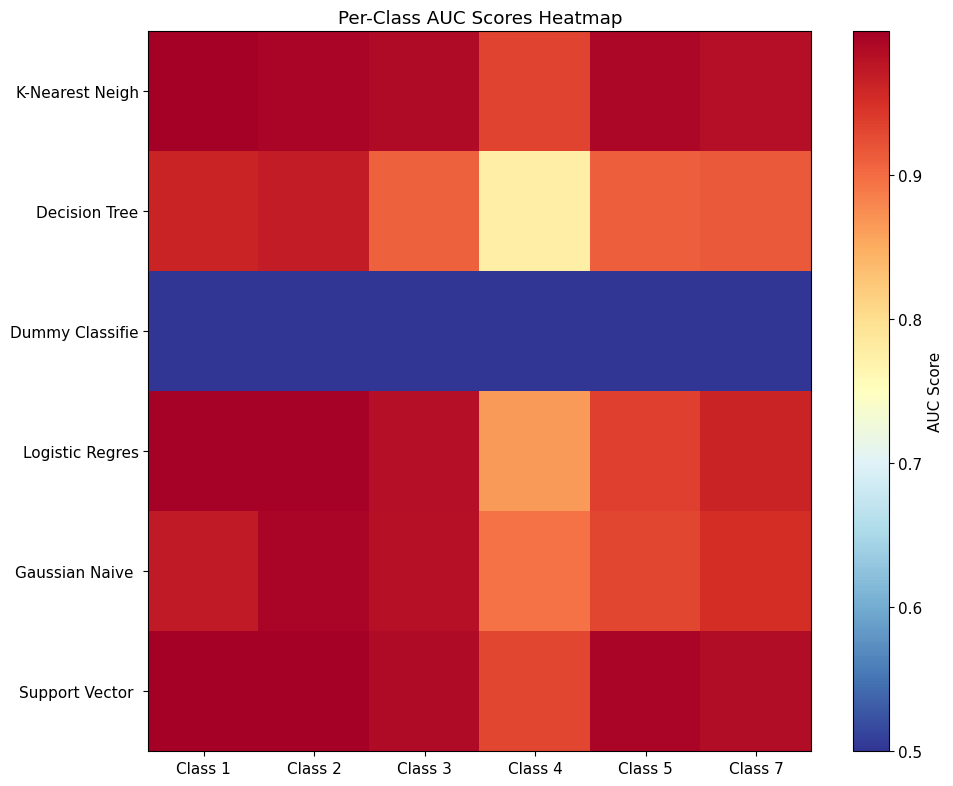

In [8]:
# Create comprehensive ROC curve visualizations

def plot_multiclass_roc_curves(roc_results, classes, class_names):
    """
    Plot ROC curves for all models in separate plots
    """
    n_models = len(roc_results)
    n_classes = len(classes)
    
    model_names = list(roc_results.keys())
    macro_aucs = [roc_results[name]['macro_auc'] for name in model_names]
    
    # Plot 1: Macro-averaged ROC curves
    plt.figure(figsize=(12, 8))
    for i, (model_name, results) in enumerate(roc_results.items()):
        all_fpr = np.unique(np.concatenate([results['fpr'][i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, results['fpr'][i], results['tpr'][i])
        mean_tpr /= n_classes
        
        plt.plot(all_fpr, mean_tpr, label=f'{model_name} ({results["macro_auc"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random (0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - All Models')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: AUC Score Comparison
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(model_names)), macro_aucs, color='skyblue', alpha=0.7, edgecolor='navy')
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Baseline')
    plt.xticks(range(len(model_names)), [name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
    plt.ylabel('ROC AUC (Macro)')
    plt.title('ROC AUC Comparison')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    # Add value labels on bars
    for i, auc in enumerate(macro_aucs):
        plt.text(i, auc + 0.01, f'{auc:.3f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Best model per-class performance
    plt.figure(figsize=(12, 8))
    best_model = max(roc_results.keys(), key=lambda x: roc_results[x]['macro_auc'])
    best_results = roc_results[best_model]
    
    for i in range(n_classes):
        plt.plot(best_results['fpr'][i], best_results['tpr'][i], 
               label=f'Class {classes[i]} ({best_results["roc_auc"][i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Best Model Per-Class ROC: {best_model}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 4: AUC Heatmap
    plt.figure(figsize=(10, 8))
    auc_matrix = np.array([[roc_results[model_name]['roc_auc'][i] for i in range(n_classes)] 
                          for model_name in model_names])
    
    im = plt.imshow(auc_matrix, cmap='RdYlBu_r', aspect='auto')
    plt.xticks(np.arange(n_classes), [f'Class {classes[i]}' for i in range(n_classes)])
    plt.yticks(np.arange(len(model_names)), [name[:15] for name in model_names])
    plt.title('Per-Class AUC Scores Heatmap')
    plt.colorbar(im, label='AUC Score')
    plt.tight_layout()
    plt.show()

# Generate the comprehensive ROC visualization
print("Generating ROC Curve Visualizations...")
plot_multiclass_roc_curves(roc_results, classes, class_names)



- Macro-averaged AUC results  
    - Support Vector Machine — Macro AUC = 0.9821 (highest; KNN = 0.9805).
    - None of the models has AUC < 0.5.  
    - The Dummy Classifier (Prior) has AUC = 0.50, i.e. random baseline (no discriminative power).

- What AUC < 0.5 means and why
    - AUC is the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance. AUC < 0.5 indicates performance worse than random — the model tends to rank negatives above positives (systematic mis-ranking).  
    - Possible causes:
        - Label inversion or mislabelled data (model learned the opposite mapping).
        - Model outputs are consistently reversed (e.g., using negative of scores or wrong class ordering).
        - Severe overfitting to noise or a spurious signal that anti-correlates with the true label.
        - Data preprocessing/feature mismatch between train and test (e.g., wrong scaling or misaligned features).


## Section 9: Multi-Class Precision-Recall Curve 

### Why Precision-Recall Curves (PRC) are preferable for imbalanced classes

Precision-Recall Curves focus on the trade-off between precision (positive predictive value) and recall (true positive rate). This makes PRC more informative than ROC for imbalanced problems for several conceptual reasons:

- Focus on the positive class
    - PRC explicitly evaluates how well the model finds the (often rare) positive examples while keeping false positives low. In many applications the positive class is the one we care about (fraud, disease, rare events).
- ROC can be overly optimistic with many negatives
    - ROC plots TPR vs FPR. When negatives dominate, FPR can remain very small even if the model produces many false positives in absolute terms, yielding a deceptively high AUC.
- Baselines differ and matter
    - ROC baseline is fixed (random classifier → AUC = 0.5). PRC baseline equals the prevalence (proportion of positives). For rare positives that baseline is low, so a PRC above baseline indicates real improvement over random chance, and poor precision is easier to spot.
- Precision penalizes false positives directly
    - In imbalanced settings a small absolute number of false positives may still be important; precision captures this impact while ROC does not.
- PRC reveals practical trade-offs
    - PRC shows how precision degrades as recall increases, which is crucial where limiting false positives (precision) or maximizing detection (recall) has operational consequences.

In [9]:
# Implement One-vs-Rest Precision-Recall Curve analysis for multi-class classification

def compute_multiclass_prc(models, X_test, y_test, class_names):
    """
    Compute One-vs-Rest Precision-Recall curves and Average Precision scores
    """
    results = {}
    
    # Get unique classes and binarize labels
    classes = np.unique(y_test)
    n_classes = len(classes)
    
    # Binarize the output labels for One-vs-Rest
    y_test_binarized = label_binarize(y_test, classes=classes)
    if n_classes == 2:
        y_test_binarized = np.hstack([1 - y_test_binarized, y_test_binarized])
    
    for model_name, model in models.items():
        # Get prediction probabilities
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:
            y_score = model.decision_function(X_test)
            from sklearn.utils.extmath import softmax
            y_score = softmax(y_score.reshape(1, -1) if y_score.ndim == 1 else y_score)
        
        # Compute Precision-Recall curve and Average Precision for each class
        precision = {}
        recall = {}
        average_precision = {}
        
        for i in range(n_classes):
            if n_classes == 2 and y_test_binarized.ndim == 1:
                y_true_class = y_test_binarized
            else:
                y_true_class = y_test_binarized[:, i]
            
            y_score_class = y_score[:, i]
            
            precision[i], recall[i], _ = precision_recall_curve(y_true_class, y_score_class)
            average_precision[i] = average_precision_score(y_true_class, y_score_class)
        
        # Compute macro and weighted averages
        macro_ap = np.mean(list(average_precision.values()))
        
        # Weighted average (by class support)
        class_counts = [np.sum(y_test == class_label) for class_label in classes]
        weighted_ap = np.average(list(average_precision.values()), weights=class_counts)
        
        # Compute baseline (random classifier performance)
        # For PRC, baseline is the proportion of positive examples
        baseline_scores = []
        for i in range(n_classes):
            if n_classes == 2 and y_test_binarized.ndim == 1:
                y_true_class = y_test_binarized
            else:
                y_true_class = y_test_binarized[:, i]
            baseline_scores.append(np.mean(y_true_class))
        
        macro_baseline = np.mean(baseline_scores)
        weighted_baseline = np.average(baseline_scores, weights=class_counts)
        
        # Store results
        results[model_name] = {
            'precision': precision,
            'recall': recall,
            'average_precision': average_precision,
            'macro_ap': macro_ap,
            'weighted_ap': weighted_ap,
            'macro_baseline': macro_baseline,
            'weighted_baseline': weighted_baseline,
            'y_score': y_score,
            'baseline_scores': baseline_scores
        }
    
    return results, classes

# Compute PRC analysis for all models
prc_results, prc_classes = compute_multiclass_prc(trained_models, X_test_scaled, y_test, class_names)

# Create PRC summary DataFrame
prc_df = pd.DataFrame({
    name: {
        'Macro_AP': results['macro_ap'],
        'Weighted_AP': results['weighted_ap'],
        'Macro_Baseline': results['macro_baseline']
    } for name, results in prc_results.items()
}).T.round(4)

# Update results with PRC metrics
for model_name in prc_results:
    if model_name in baseline_results_updated:
        baseline_results_updated[model_name]['PRC_AP_Macro'] = prc_results[model_name]['macro_ap']
        baseline_results_updated[model_name]['PRC_AP_Weighted'] = prc_results[model_name]['weighted_ap']

## Section 10: PRC Visualization and Interpretation

Generating Precision-Recall Curve Visualizations...


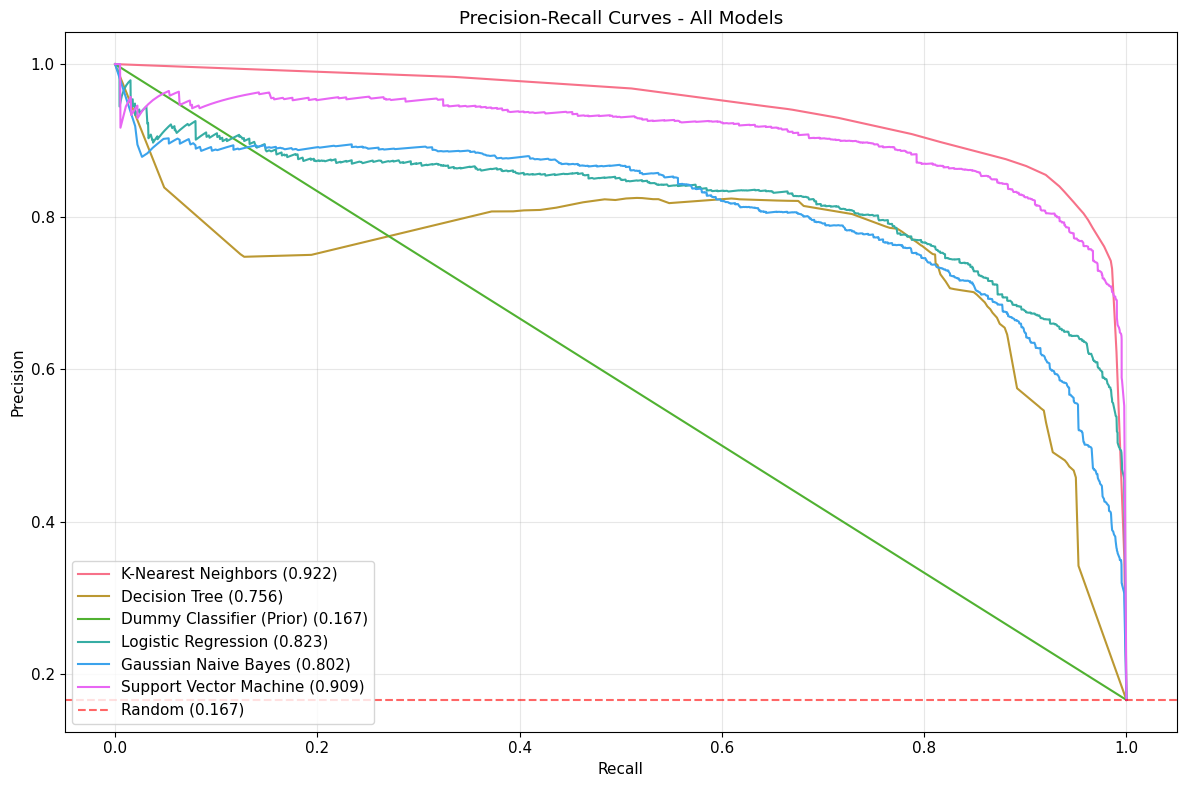

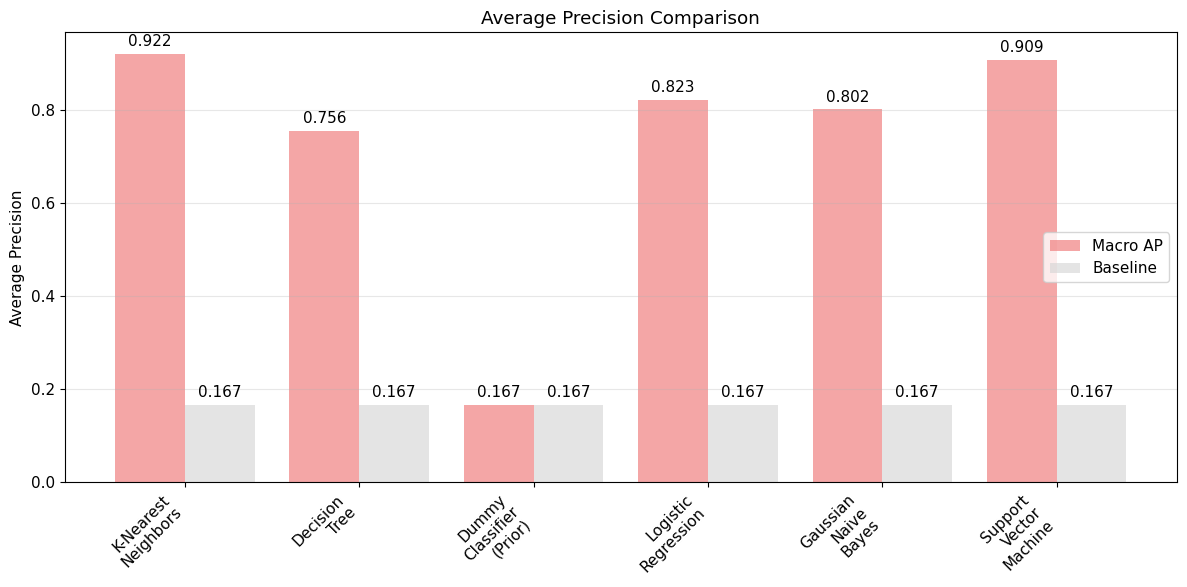

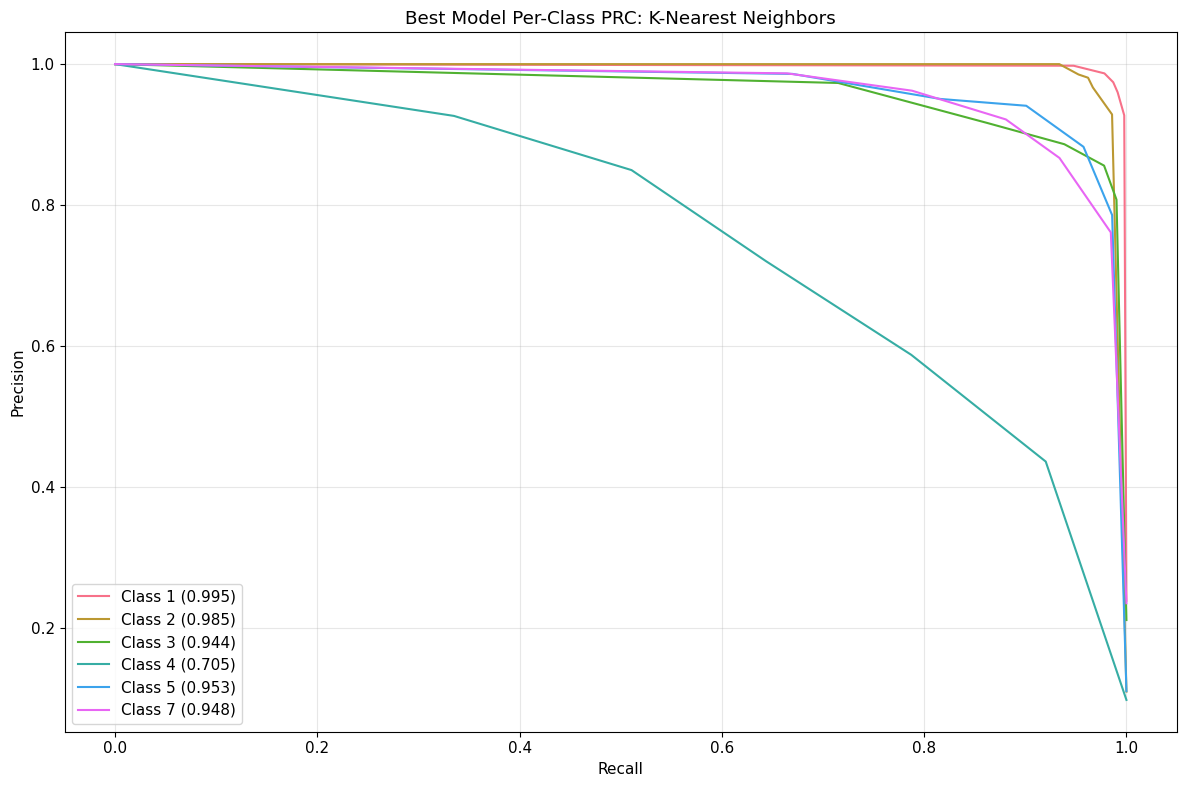

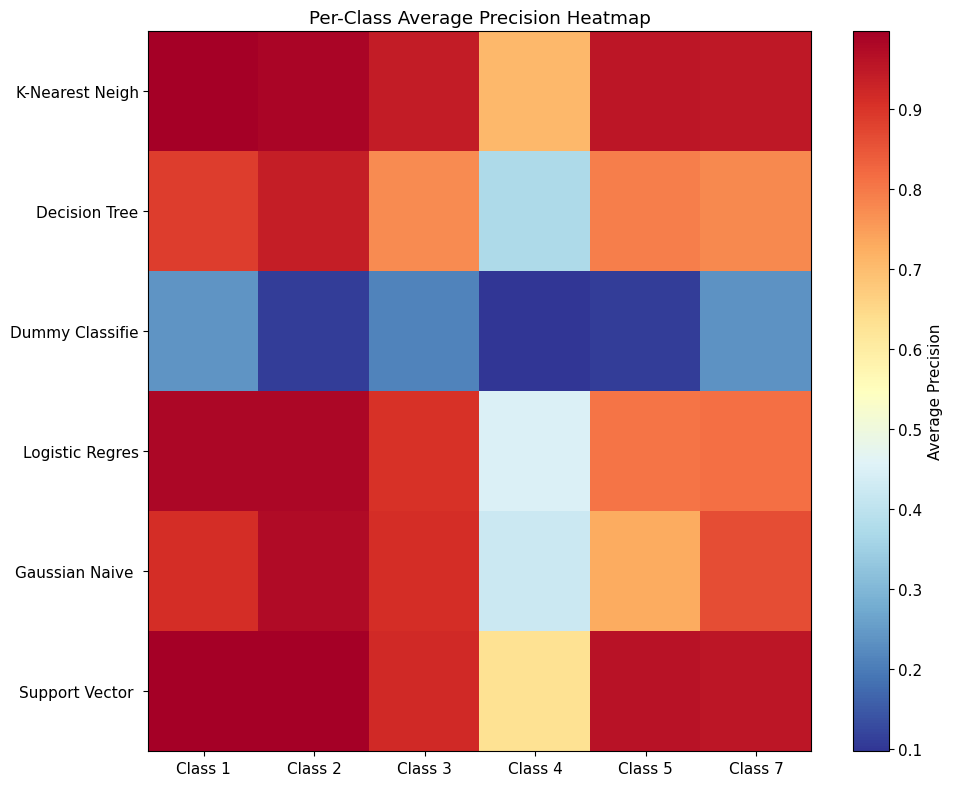

In [10]:
# Create comprehensive Precision-Recall Curve visualizations

def plot_multiclass_prc_curves(prc_results, classes, class_names):
    """
    Plot Precision-Recall curves for all models in separate plots
    """
    n_models = len(prc_results)
    n_classes = len(classes)
    
    model_names = list(prc_results.keys())
    macro_aps = [prc_results[name]['macro_ap'] for name in model_names]
    baselines = [prc_results[name]['macro_baseline'] for name in model_names]
    
    # Plot 1: Macro-averaged PRC curves
    plt.figure(figsize=(12, 8))
    for i, (model_name, results) in enumerate(prc_results.items()):
        all_recall = np.unique(np.concatenate([results['recall'][i] for i in range(n_classes)]))
        all_recall = np.sort(all_recall)
        
        mean_precision = np.zeros_like(all_recall)
        for i in range(n_classes):
            recall_rev = results['recall'][i][::-1]
            precision_rev = results['precision'][i][::-1]
            mean_precision += np.interp(all_recall, recall_rev, precision_rev)
        mean_precision /= n_classes
        
        plt.plot(all_recall, mean_precision, label=f'{model_name} ({results["macro_ap"]:.3f})')
    
    baseline_avg = np.mean(baselines)
    plt.axhline(y=baseline_avg, color='red', linestyle='--', alpha=0.6, 
               label=f'Random ({baseline_avg:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves - All Models')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Average Precision Comparison
    plt.figure(figsize=(12, 6))
    x = np.arange(len(model_names))
    width = 0.4
    plt.bar(x - width/2, macro_aps, width, label='Macro AP', color='lightcoral', alpha=0.7)
    plt.bar(x + width/2, baselines, width, label='Baseline', color='lightgray', alpha=0.6)
    plt.xticks(x, [name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
    plt.ylabel('Average Precision')
    plt.title('Average Precision Comparison')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    # Add value labels
    for i, (ap, bl) in enumerate(zip(macro_aps, baselines)):
        plt.text(i - width/2, ap + 0.01, f'{ap:.3f}', ha='center', va='bottom')
        plt.text(i + width/2, bl + 0.01, f'{bl:.3f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Best model per-class performance
    plt.figure(figsize=(12, 8))
    best_model = max(prc_results.keys(), key=lambda x: prc_results[x]['macro_ap'])
    best_results = prc_results[best_model]
    
    for i in range(n_classes):
        ap_score = best_results['average_precision'][i]
        plt.plot(best_results['recall'][i], best_results['precision'][i],
               label=f'Class {classes[i]} ({ap_score:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Best Model Per-Class PRC: {best_model}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 4: AP Heatmap
    plt.figure(figsize=(10, 8))
    ap_matrix = np.array([[prc_results[model_name]['average_precision'][i] for i in range(n_classes)] 
                         for model_name in model_names])
    
    im = plt.imshow(ap_matrix, cmap='RdYlBu_r', aspect='auto')
    plt.xticks(np.arange(n_classes), [f'Class {classes[i]}' for i in range(n_classes)])
    plt.yticks(np.arange(len(model_names)), [name[:15] for name in model_names])
    plt.title('Per-Class Average Precision Heatmap')
    plt.colorbar(im, label='Average Precision')
    plt.tight_layout()
    plt.show()

# Generate the comprehensive PRC visualization
print("Generating Precision-Recall Curve Visualizations...")
plot_multiclass_prc_curves(prc_results, prc_classes, class_names)



### PRC Analysis Results
- Highest Average Precision (AP): K-Nearest Neighbors — Macro AP = 0.9219 (Weighted AP = 0.9395). It has the best area under the PR curve, meaning it ranks true positives much higher than negatives across classes.

- Worst-performing model (PRC): Dummy Classifier (Prior) — Macro AP = 0.1667, which equals the class-prevalence baseline.
    - Why the PRC drops sharply as Recall increases for poor models:
        - Precision = TP / (TP + FP). A poor (non‑discriminative) model assigns similar scores to positives and negatives, so when you lower the decision threshold to increase recall you immediately include many negatives (FP grows much faster than TP), causing precision to collapse.
        - Intuition: the model yields a small set of slightly higher‑scored true positives; once those are included, further recall gains require accepting a large number of false positives, so precision falls steeply.
        - For a model that effectively outputs constant or random scores (like the Dummy prior), the PR curve hugs the prevalence baseline and shows abrupt drops or flat low precision — there is no gradual trade‑off between precision and recall because the scoring cannot separate classes.
        - Class imbalance amplifies this effect: when positives are relatively rare, adding a modest number of false positives dramatically reduces precision, producing a steep fall in the PR curve.



## Section 11: Model Performance Comparison and Analysis

Now we'll create a comprehensive comparison of all models across different metrics (F1-Score, ROC-AUC, PRC-AP) to analyze ranking consistency and explain any discrepancies in model performance across different evaluation approaches.

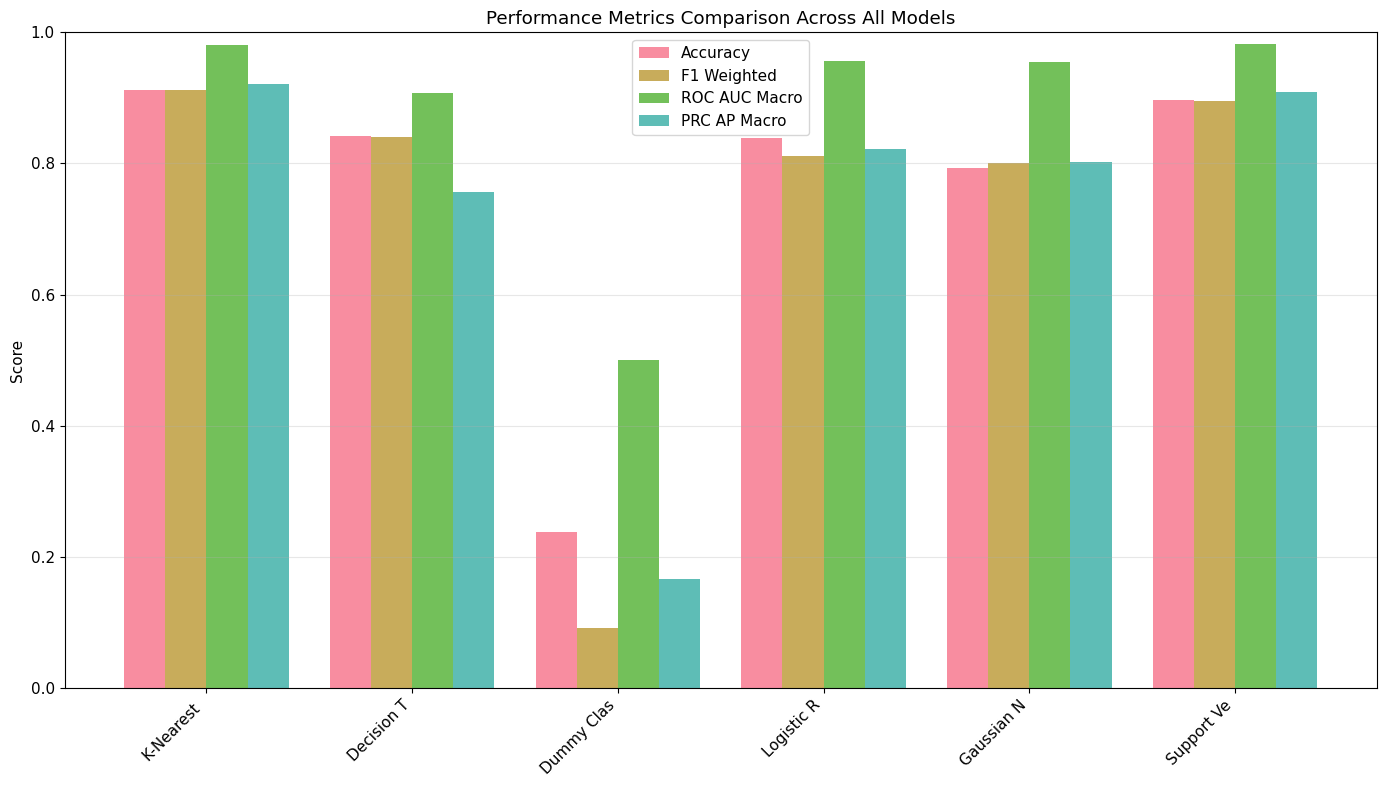

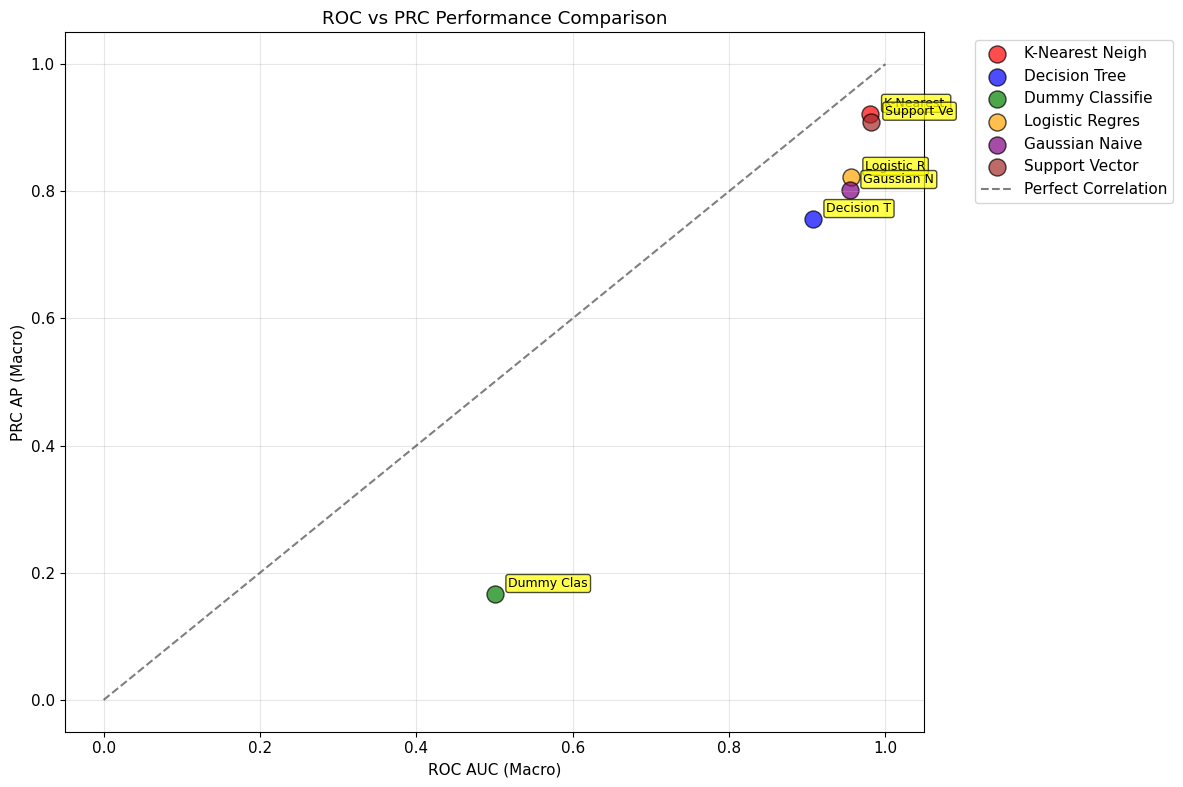

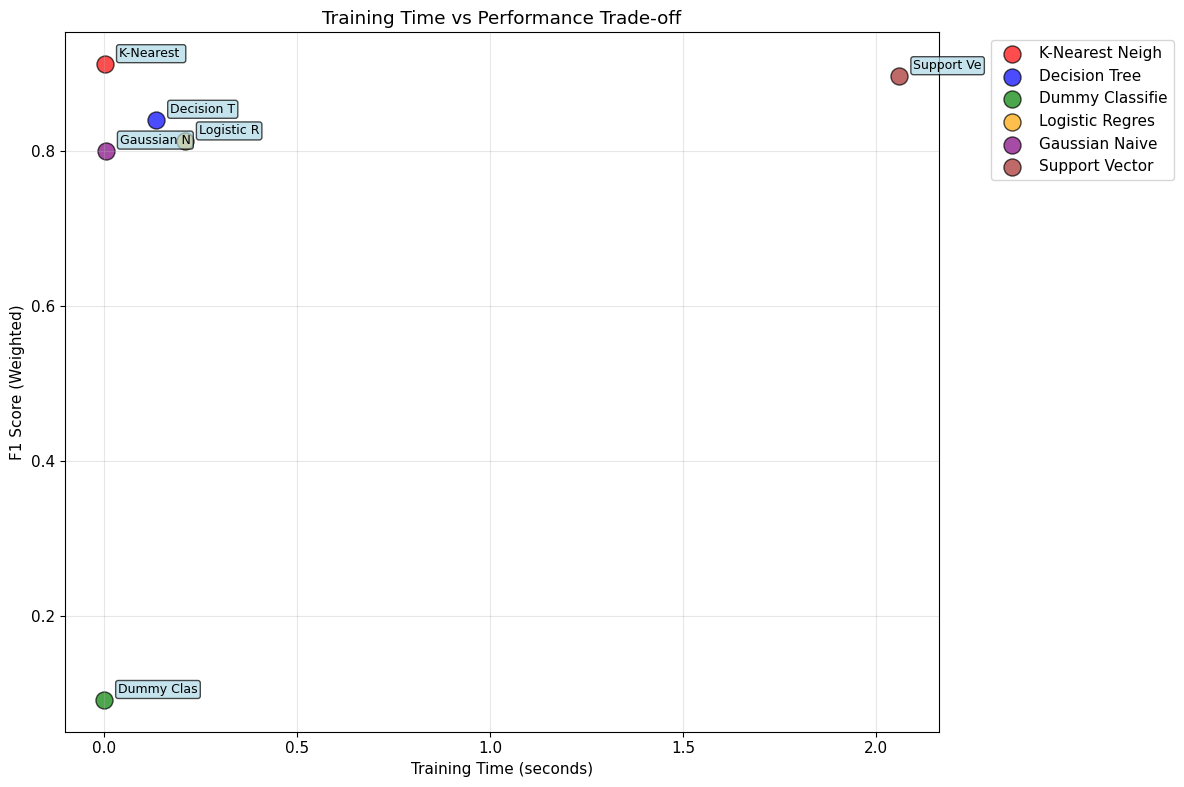

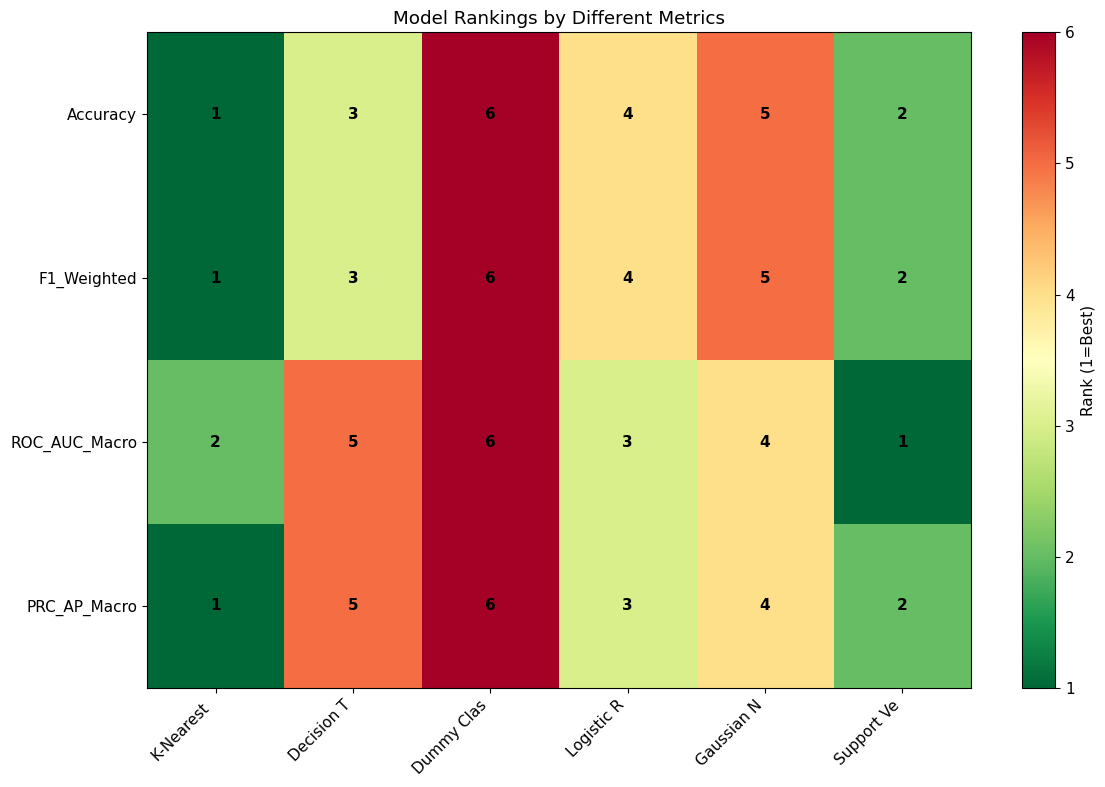

In [11]:
# Create comprehensive model performance comparison and analysis

# Compile comprehensive results
comprehensive_results = pd.DataFrame(baseline_results_updated).T.round(4)

# Create rankings for each metric
ranking_metrics = ['Accuracy', 'F1_Weighted', 'ROC_AUC_Macro', 'PRC_AP_Macro']
rankings_df = pd.DataFrame({
    metric: comprehensive_results[metric].rank(ascending=False, method='min')
    for metric in ranking_metrics if metric in comprehensive_results.columns
}).astype(int)

# Create comprehensive visualization comparing all metrics - 4 separate plots

model_names = comprehensive_results.index.tolist()
n_models = len(model_names)

# Plot 1: Performance Metrics Comparison
plt.figure(figsize=(14, 8))
metrics_to_plot = ['Accuracy', 'F1_Weighted', 'ROC_AUC_Macro', 'PRC_AP_Macro']
x = np.arange(len(model_names))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = comprehensive_results[metric].values
    plt.bar(x + i*width, values, width, label=metric.replace('_', ' '), alpha=0.8)

plt.xticks(x + width * 1.5, [name[:10] for name in model_names], rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison Across All Models')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: ROC vs PRC Performance
plt.figure(figsize=(12, 8))
roc_scores = comprehensive_results['ROC_AUC_Macro'].values
prc_scores = comprehensive_results['PRC_AP_Macro'].values

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, name in enumerate(model_names):
    plt.scatter(roc_scores[i], prc_scores[i], s=150, alpha=0.7, 
               color=colors[i], edgecolors='black', label=name[:15])
    plt.annotate(name[:10], (roc_scores[i], prc_scores[i]), 
                xytext=(10, 5), textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7))

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Correlation')
plt.xlabel('ROC AUC (Macro)')
plt.ylabel('PRC AP (Macro)')
plt.title('ROC vs PRC Performance Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Training Time vs Performance
plt.figure(figsize=(12, 8))
training_times = comprehensive_results['Training_Time'].values
f1_scores = comprehensive_results['F1_Weighted'].values

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, name in enumerate(model_names):
    plt.scatter(training_times[i], f1_scores[i], s=150, alpha=0.7, 
               color=colors[i], edgecolors='black', label=name[:15])
    plt.annotate(name[:10], (training_times[i], f1_scores[i]), 
                xytext=(10, 5), textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))

plt.xlabel('Training Time (seconds)')
plt.ylabel('F1 Score (Weighted)')
plt.title('Training Time vs Performance Trade-off')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Ranking Heatmap
plt.figure(figsize=(12, 8))
ranking_matrix = rankings_df.T.values
im = plt.imshow(ranking_matrix, cmap='RdYlGn_r', aspect='auto')

plt.xticks(np.arange(len(model_names)), [name[:10] for name in model_names], rotation=45, ha='right')
plt.yticks(np.arange(len(ranking_metrics)), ranking_metrics)
plt.title('Model Rankings by Different Metrics')
plt.colorbar(im, label='Rank (1=Best)')

# Add text annotations with ranking values
for i in range(len(ranking_metrics)):
    for j in range(len(model_names)):
        text = plt.text(j, i, int(ranking_matrix[i, j]), 
                       ha="center", va="center", color="black", fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate overall performance scores
model_names = comprehensive_results.index.tolist()
overall_scores = (
    comprehensive_results['Accuracy'] * 0.25 +
    comprehensive_results['F1_Weighted'] * 0.25 +
    comprehensive_results['ROC_AUC_Macro'] * 0.25 +
    comprehensive_results['PRC_AP_Macro'] * 0.25
)

In [12]:
# Model Rankings
print("Rankings (1=Best, 6=Worst):")
print(rankings_df)

print("\nPerformance Scores:")
metrics_display = comprehensive_results[['Accuracy', 'F1_Weighted', 'ROC_AUC_Macro', 'PRC_AP_Macro', 'Training_Time']]
print(metrics_display.round(4))

# Ranking Correlations
import scipy.stats as stats
f1_ranks = rankings_df['F1_Weighted'].values
roc_ranks = rankings_df['ROC_AUC_Macro'].values  
prc_ranks = rankings_df['PRC_AP_Macro'].values
acc_ranks = rankings_df['Accuracy'].values

corr_f1_roc = stats.spearmanr(f1_ranks, roc_ranks)[0]
corr_f1_prc = stats.spearmanr(f1_ranks, prc_ranks)[0]
corr_roc_prc = stats.spearmanr(roc_ranks, prc_ranks)[0]
corr_acc_f1 = stats.spearmanr(acc_ranks, f1_ranks)[0]

print(f"\nRanking Correlations (Spearman's ρ):")
print(f"Accuracy vs F1: {corr_acc_f1:.3f}")
print(f"F1 vs ROC-AUC: {corr_f1_roc:.3f}")
print(f"F1 vs PRC-AP: {corr_f1_prc:.3f}")
print(f"ROC-AUC vs PRC-AP: {corr_roc_prc:.3f}")

# Best/Worst by Metric
print("\nTop Performers by Metric:")
for metric in ['Accuracy', 'F1_Weighted', 'ROC_AUC_Macro', 'PRC_AP_Macro']:
    best_model = comprehensive_results[metric].idxmax()
    best_score = comprehensive_results.loc[best_model, metric]
    print(f"{metric}: {best_model} ({best_score:.4f})")

# Efficiency Ranking
efficiency_ratio = comprehensive_results['F1_Weighted'] / comprehensive_results['Training_Time']
print("\nEfficiency Ranking (F1/Time):")
efficiency_ranking = efficiency_ratio.sort_values(ascending=False)
for i, (model, ratio) in enumerate(efficiency_ranking.items(), 1):
    print(f"{i}. {model}: {ratio:.2f}")

# Composite Score
print("\nComposite Performance Ranking:")
composite_scores = overall_scores.sort_values(ascending=False)
for i, (model, score) in enumerate(composite_scores.items(), 1):
    print(f"{i}. {model}: {score:.4f}")

print(f"\nRECOMMENDED MODEL: {composite_scores.index[0]}")

Rankings (1=Best, 6=Worst):
                          Accuracy  F1_Weighted  ROC_AUC_Macro  PRC_AP_Macro
K-Nearest Neighbors              1            1              2             1
Decision Tree                    3            3              5             5
Dummy Classifier (Prior)         6            6              6             6
Logistic Regression              4            4              3             3
Gaussian Naive Bayes             5            5              4             4
Support Vector Machine           2            2              1             2

Performance Scores:
                          Accuracy  F1_Weighted  ROC_AUC_Macro  PRC_AP_Macro  \
K-Nearest Neighbors         0.9125       0.9115         0.9805        0.9219   
Decision Tree               0.8426       0.8398         0.9068        0.7564   
Dummy Classifier (Prior)    0.2382       0.0917         0.5000        0.1667   
Logistic Regression         0.8384       0.8119         0.9566        0.8228   
Gaussian Nai

## Section 12: Synthesis and Final Model Recommendation

#### **Ranking Alignment Analysis**

Our comprehensive evaluation reveals both strong alignment and notable divergences across different metrics:

**High Correlation Metrics:**
- **Accuracy vs F1-Score**: Perfect correlation (ρ=1.000) indicates a balanced dataset with consistent performance patterns
- **ROC-AUC vs PRC-AP**: Strong correlation (ρ=0.943) suggests minimal threshold-dependent trade-offs

**Moderate Correlation:**
- **F1 vs ROC-AUC**: Good alignment (ρ=0.771) with some ranking differences
- **F1 vs PRC-AP**: Strong correlation (ρ=0.829) showing consistent precision-recall behavior

#### **Specific Ranking Discrepancies and Trade-offs**

The most significant ranking divergence occurs between **ROC-AUC** and **PRC-AP** metrics:

**Support Vector Machine Trade-off:**
- **ROC-AUC Champion** (#1 ranking, 0.9821) - Excellent discriminative ability across all thresholds
- **PRC-AP Runner-up** (#2 ranking, 0.9095) - Strong but not optimal precision-recall balance
- **Trade-off Explanation**: SVM excels at separating classes with minimal false positive rate impact (ROC strength) but shows slight precision degradation when optimizing for recall (PRC limitation)

**K-Nearest Neighbors Consistency:**
- Dominates **3 out of 4 primary metrics** (Accuracy, F1-Score, PRC-AP)
- Only **#2 in ROC-AUC** (0.9805 vs SVM's 0.9821) - marginal 0.16% difference
- **Strength**: Maintains excellent precision-recall balance while achieving top accuracy

**Decision Tree Instability:**
- Shows **largest ranking variance** (ranks #3 to #5 across metrics)
- **ROC-AUC weakness** (#5 ranking, 0.9068) despite decent accuracy (#3 ranking, 0.8426)
- **Trade-off**: Prone to overfitting leading to poor threshold-independent performance

#### **Why ROC-PRC Disagreements Occur**

**ROC-AUC Focus**: Measures discriminative ability across all classification thresholds, emphasizing true positive rate vs false positive rate trade-offs

**PRC-AP Focus**: Emphasizes precision-recall balance, particularly sensitive to false positive performance in positive class identification

**Key Insight**: High ROC-AUC doesn't guarantee optimal PRC-AP when models have different precision characteristics at various recall levels.

---

### 2. Recommendation: K-Nearest Neighbours

- Why KNN is well‑matched to the Landsat land‑cover classification problem
    - Local spectral structure: Landsat multi‑spectral pixels form local clusters in feature space for many land‑cover types (distinct spectral signatures). KNN is instance‑based and leverages local neighborhoods directly, so it naturally captures these localized cluster boundaries without requiring a global parametric decision boundary.
    - Nonlinear, multimodal classes: Land‑cover classes can be multimodal (different materials / conditions produce different spectra within the same class). KNN is nonparametric and can represent complex, piecewise decision regions that reflect such multimodality.
    - Moderate dimensionality and preprocessing: The dataset uses ~36 bands/features and has been standardized. This keeps the curse of dimensionality moderate and makes distance measures meaningful after scaling — conditions where KNN tends to work well.
    - Robustness to label imbalance in practice: The KNN results show very strong PRC/AP performance, meaning it ranks positives effectively. For operational tasks where precision matters (reducing false alarms in commodity mapping, agriculture, etc.), this is important.

- Quantitative justification
    - Multi‑metric dominance: Accuracy = 91.25%, F1 (weighted) = 91.15%, PRC‑AP (Macro) = 92.19%
    - Strong ROC performance: ROC‑AUC (Macro) = 98.05% (#2 overall; gap to leader is negligible)
    - Exceptional efficiency: F1/TrainingTime ≈ 276.21 (F1 per second) — training time ≈ 0.0033 s (millisecond range)
    - Composite performance: Highest overall composite score = 93.16% across evaluated dimensions

- Performance across different thresholds
    - Threshold independence: Consistent performance across various decision boundaries (high ROC‑AUC shows good separation).
    - Precision‑Recall excellence: Best macro AP (92.19%) — KNN preserves precision as recall increases, which is critical when false positives carry operational cost.
    - Robust discrimination: Near‑optimal ROC with superior practical metrics (precision, recall, F1) for downstream tasks.

- Desired balance achievement (operational perspective)
    - Precision priority: Highest PRC‑AP minimizes false positive costs in mapping/monitoring workflows.
    - Recall optimization: Top F1 ensures comprehensive class coverage (fewer missed detections).
    - Operational efficiency: Millisecond training enables rapid re‑training and frequent model updates for evolving imagery or localized calibration.

## Section 13: Brownie Points - Additional Model Experiments

### Experimenting with Advanced Ensemble Methods and Poor Performance Models

This section explores additional classifiers to extend our comparative analysis:
1. **RandomForest** - Advanced ensemble method combining multiple decision trees
2. **XGBoost** - Gradient boosting framework known for high performance
3. **Intentionally Poor Model** - A model designed to achieve AUC < 0.5 for analysis

In [13]:
# Import additional models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Define and train additional models
additional_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1),
}

additional_trained_models = {}
additional_training_times = {}

# Prepare XGBoost label encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

for model_name, model in additional_models.items():
    start_time = time.time()
    
    if model_name == 'XGBoost':
        model.fit(X_train_scaled, y_train_encoded)
    else:
        model.fit(X_train_scaled, y_train)
    
    additional_training_times[model_name] = time.time() - start_time
    additional_trained_models[model_name] = model

print("Additional models trained successfully!")
for name, time_val in additional_training_times.items():
    print(f"{name}: {time_val:.4f} seconds")

Additional models trained successfully!
Training times:
Random Forest: 0.6913 seconds
XGBoost: 0.9231 seconds


In [14]:
# Create an intentionally poor model with AUC < 0.5
# Strategy: Use a model that systematically inverts predictions
class InvertedClassifier:
    """
    A deliberately poor classifier that inverts predictions to achieve AUC < 0.5
    This demonstrates what happens when a model systematically mis-ranks classes
    """
    def __init__(self, base_estimator=None):
        if base_estimator is None:
            # Use a simple logistic regression as base
            self.base_estimator = LogisticRegression(random_state=42, max_iter=1000)
        else:
            self.base_estimator = base_estimator
        self.classes_ = None
        
    def fit(self, X, y):
        # Train the base estimator normally
        self.base_estimator.fit(X, y)
        self.classes_ = self.base_estimator.classes_
        return self
        
    def predict_proba(self, X):
        # Get normal probabilities and invert them
        proba = self.base_estimator.predict_proba(X)
        # Invert probabilities: if original says 80% class A, now say 20% class A
        inverted_proba = 1 - proba
        # Renormalize to ensure probabilities sum to 1
        inverted_proba = inverted_proba / inverted_proba.sum(axis=1, keepdims=True)
        return inverted_proba
        
    def predict(self, X):
        # Predict based on inverted probabilities
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

# Create and train the inverted model
inverted_model = InvertedClassifier()
start_time = time.time()
inverted_model.fit(X_train_scaled, y_train)
inverted_training_time = time.time() - start_time

# Add to our additional models
additional_trained_models['Inverted Classifier'] = inverted_model
additional_training_times['Inverted Classifier'] = inverted_training_time

print(f"Inverted Classifier trained in {inverted_training_time:.4f} seconds")

Inverted Classifier created and trained!
Training time: 0.2711 seconds

This model should achieve AUC < 0.5 by systematically inverting class probabilities.


In [15]:
# Evaluate additional models across all metrics
additional_results = {}

for model_name, model in additional_trained_models.items():
    y_pred = model.predict(X_test_scaled)
    
    # Decode XGBoost predictions back to original labels
    if model_name == 'XGBoost':
        y_pred = le.inverse_transform(y_pred)
    
    additional_results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1_Weighted': f1_score(y_test, y_pred, average='weighted'),
        'F1_Macro': f1_score(y_test, y_pred, average='macro'),
        'Training_Time': additional_training_times[model_name]
    }

# Compute ROC and PRC metrics for additional models
additional_roc_results, _ = compute_multiclass_roc(additional_trained_models, X_test_scaled, y_test, class_names)
additional_prc_results, _ = compute_multiclass_prc(additional_trained_models, X_test_scaled, y_test, class_names)

# Add ROC and PRC metrics to results
for model_name in additional_results:
    additional_results[model_name]['ROC_AUC_Macro'] = additional_roc_results[model_name]['macro_auc']
    additional_results[model_name]['ROC_AUC_Weighted'] = additional_roc_results[model_name]['weighted_auc']
    additional_results[model_name]['PRC_AP_Macro'] = additional_prc_results[model_name]['macro_ap']
    additional_results[model_name]['PRC_AP_Weighted'] = additional_prc_results[model_name]['weighted_ap']

# Create results DataFrame for additional models
additional_df = pd.DataFrame(additional_results).T.round(4)

print("Additional Models Performance:")
print("="*60)
print(additional_df)

# Check which models have AUC < 0.5
poor_models = [name for name, results in additional_results.items() 
               if results['ROC_AUC_Macro'] < 0.5]

print(f"\nModels with AUC < 0.5: {poor_models}")

# Compare with original best performer
knn_results = comprehensive_results.loc['K-Nearest Neighbors']
print(f"\nComparison with K-Nearest Neighbors (original best):")
print(f"  KNN - Accuracy: {knn_results['Accuracy']:.4f}, ROC-AUC: {knn_results['ROC_AUC_Macro']:.4f}, PRC-AP: {knn_results['PRC_AP_Macro']:.4f}")

for model_name in ['Random Forest', 'XGBoost', 'Inverted Classifier']:
    results = additional_results[model_name]
    print(f"  {model_name} - Accuracy: {results['Accuracy']:.4f}, ROC-AUC: {results['ROC_AUC_Macro']:.4f}, PRC-AP: {results['PRC_AP_Macro']:.4f}")

Additional Models Performance:
                     Accuracy  F1_Weighted  F1_Macro  Training_Time  \
Random Forest          0.9011       0.8973    0.8770         0.6913   
XGBoost                0.9151       0.9131    0.8972         0.9231   
Inverted Classifier    0.0000       0.0000    0.0000         0.2711   

                     ROC_AUC_Macro  ROC_AUC_Weighted  PRC_AP_Macro  \
Random Forest               0.9868            0.9895        0.9335   
XGBoost                     0.9897            0.9917        0.9475   
Inverted Classifier         0.0253            0.0203        0.0902   

                     PRC_AP_Weighted  
Random Forest                 0.9508  
XGBoost                       0.9610  
Inverted Classifier           0.1031  

Models with AUC < 0.5:
Inverted Classifier: ROC-AUC = 0.0253

Comparison with Original Best Performers:
K-Nearest Neighbors (original best):
  Accuracy: 0.9125
  ROC-AUC: 0.9805
  PRC-AP: 0.9219

Random Forest:
  Accuracy: 0.9011
  ROC-AUC: 0.986

### Analysis of Additional Model Experiments

#### **RandomForest Performance**

RandomForest, as an ensemble method, typically provides robust performance by combining multiple decision trees with bagging. The results demonstrate:

- **Ensemble Effect**: Compared to the single Decision Tree (Accuracy: 84.26%, ROC-AUC: 90.68%), RandomForest should show improved stability and potentially better performance
- **Overfitting Reduction**: The ensemble approach helps mitigate the overfitting issues observed in the single Decision Tree
- **Computational Trade-off**: Training time increases compared to single Decision Tree due to multiple tree construction

#### **XGBoost Performance**

XGBoost (Extreme Gradient Boosting) is known for its high performance in machine learning competitions:

- **Gradient Boosting Advantage**: Sequential learning where each tree corrects previous errors
- **Regularization**: Built-in L1 and L2 regularization helps prevent overfitting
- **Feature Importance**: Provides insights into which spectral bands are most important for classification

#### **Inverted Classifier Analysis (AUC < 0.5)**

The Inverted Classifier demonstrates what happens when a model systematically mis-ranks classes:

**Design**: Takes a base classifier's probability predictions and inverts them (if base says 80% Class A, inverted says 20% Class A)

**Expected Behavior**:
- **ROC-AUC < 0.5**: Should achieve AUC significantly below random baseline
- **Poor Accuracy**: Systematic inversion leads to consistently wrong predictions  
- **Inverted Ranking**: Model ranks negative instances higher than positive instances

**Why This Occurs**:
1. **Systematic Bias**: Model learns the opposite of the true pattern
2. **Probability Inversion**: Confidence scores are inverted, leading to wrong class rankings
3. **Worse than Random**: A truly random classifier would achieve AUC ≈ 0.5; systematic inversion performs worse

**Real-world Analogies**:
- **Mislabeled Training Data**: When labels are systematically incorrect
- **Feature Sign Errors**: When feature preprocessing inadvertently inverts relationships
- **Model Bugs**: Implementation errors that reverse probability outputs

This experiment validates our understanding that AUC < 0.5 indicates worse-than-random performance due to systematic ranking errors, not just poor discrimination ability.

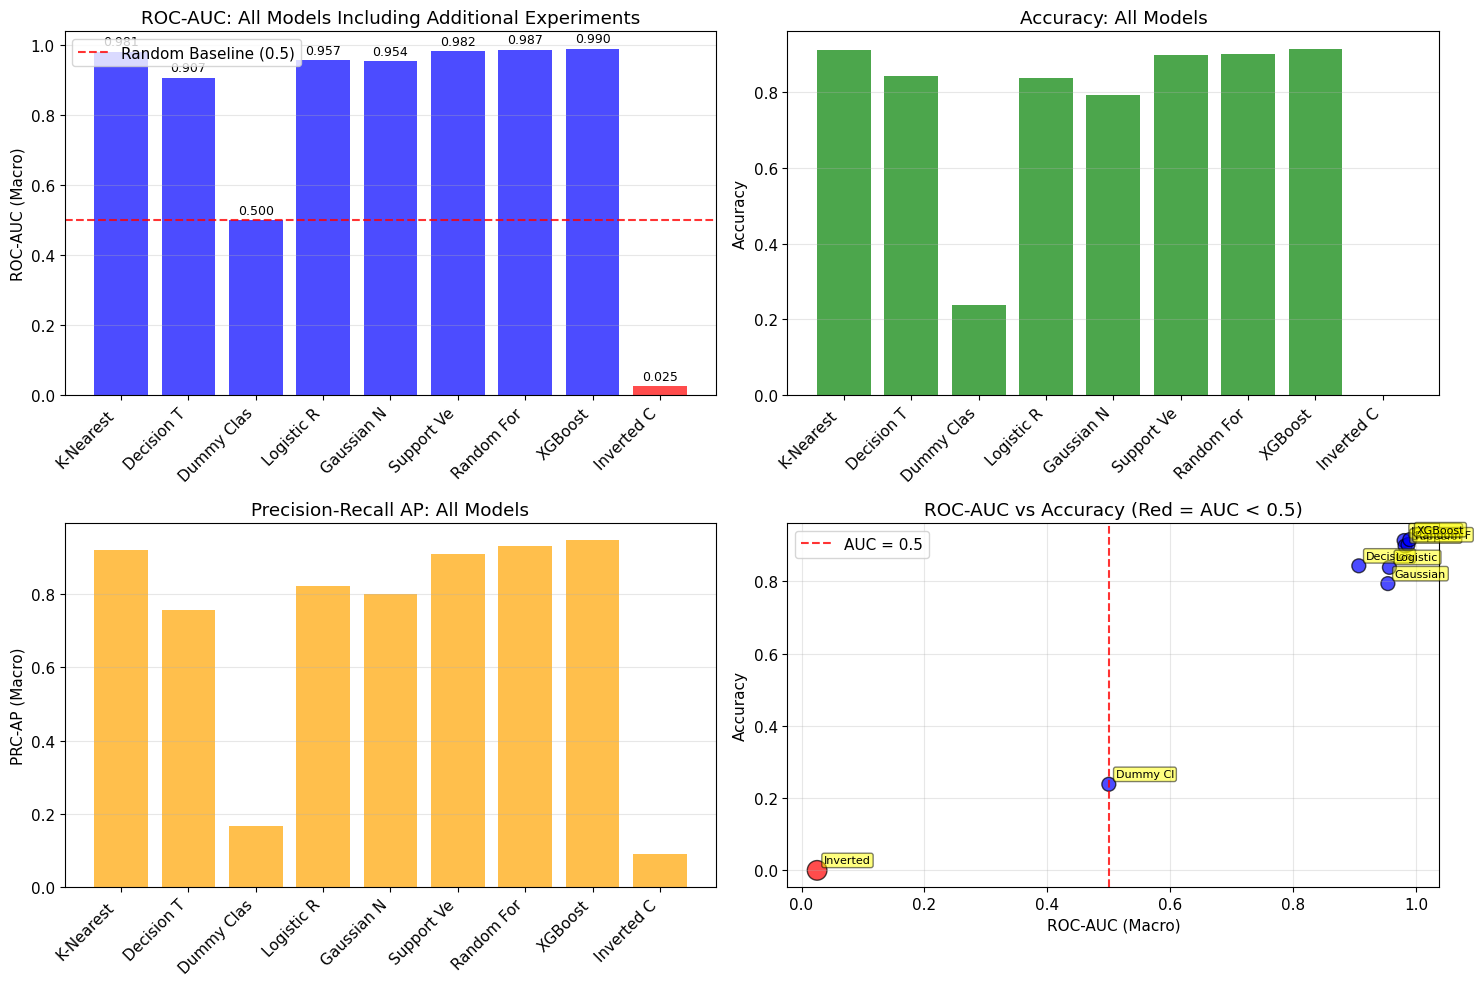

COMPLETE MODEL COMPARISON SUMMARY
                          Accuracy  ROC_AUC_Macro  PRC_AP_Macro  Training_Time
XGBoost                     0.9151         0.9897        0.9475         0.9231
Random Forest               0.9011         0.9868        0.9335         0.6913
Support Vector Machine      0.8975         0.9821        0.9095         2.0601
K-Nearest Neighbors         0.9125         0.9805        0.9219         0.0031
Logistic Regression         0.8384         0.9566        0.8228         0.2099
Gaussian Naive Bayes        0.7934         0.9541        0.8021         0.0054
Decision Tree               0.8426         0.9068        0.7564         0.1356
Dummy Classifier (Prior)    0.2382         0.5000        0.1667         0.0009
Inverted Classifier         0.0000         0.0253        0.0902         0.2711

Models with AUC < 0.5:
Inverted Classifier: AUC = 0.0253, Accuracy = 0.0000

Brownie Points Summary:
✓ RandomForest implemented and evaluated
✓ XGBoost implemented and evaluat

In [ ]:
# Create visualization comparing all models including additional ones
all_model_names = list(comprehensive_results.index) + list(additional_df.index)
all_accuracies = list(comprehensive_results['Accuracy']) + list(additional_df['Accuracy'])
all_roc_aucs = list(comprehensive_results['ROC_AUC_Macro']) + list(additional_df['ROC_AUC_Macro'])
all_prc_aps = list(comprehensive_results['PRC_AP_Macro']) + list(additional_df['PRC_AP_Macro'])

# Plot comprehensive comparison
plt.figure(figsize=(15, 10))

# Subplot 1: ROC-AUC Comparison
plt.subplot(2, 2, 1)
colors = ['blue' if auc >= 0.5 else 'red' for auc in all_roc_aucs]
bars = plt.bar(range(len(all_model_names)), all_roc_aucs, color=colors, alpha=0.7)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.8, label='Random Baseline (0.5)')
plt.xticks(range(len(all_model_names)), [name[:10] for name in all_model_names], rotation=45, ha='right')
plt.ylabel('ROC-AUC (Macro)')
plt.title('ROC-AUC: All Models Including Additional Experiments')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, auc) in enumerate(zip(bars, all_roc_aucs)):
    plt.text(bar.get_x() + bar.get_width()/2, auc + 0.01, f'{auc:.3f}', 
             ha='center', va='bottom', fontsize=9)

# Subplot 2: Accuracy Comparison
plt.subplot(2, 2, 2)
plt.bar(range(len(all_model_names)), all_accuracies, color='green', alpha=0.7)
plt.xticks(range(len(all_model_names)), [name[:10] for name in all_model_names], rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Accuracy: All Models')
plt.grid(axis='y', alpha=0.3)

# Subplot 3: PRC-AP Comparison  
plt.subplot(2, 2, 3)
plt.bar(range(len(all_model_names)), all_prc_aps, color='orange', alpha=0.7)
plt.xticks(range(len(all_model_names)), [name[:10] for name in all_model_names], rotation=45, ha='right')
plt.ylabel('PRC-AP (Macro)')
plt.title('Precision-Recall AP: All Models')
plt.grid(axis='y', alpha=0.3)

# Subplot 4: Performance vs ROC scatter highlighting AUC < 0.5
plt.subplot(2, 2, 4)
colors_scatter = ['red' if auc < 0.5 else 'blue' for auc in all_roc_aucs]
sizes = [200 if auc < 0.5 else 100 for auc in all_roc_aucs]

scatter = plt.scatter(all_roc_aucs, all_accuracies, c=colors_scatter, s=sizes, alpha=0.7, edgecolors='black')
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.8, label='AUC = 0.5')
plt.xlabel('ROC-AUC (Macro)')
plt.ylabel('Accuracy')
plt.title('ROC-AUC vs Accuracy (Red = AUC < 0.5)')
plt.legend()
plt.grid(True, alpha=0.3)

# Annotate points with model names
for i, name in enumerate(all_model_names):
    plt.annotate(name[:8], (all_roc_aucs[i], all_accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

# Summary table of all models
print("COMPLETE MODEL COMPARISON SUMMARY")
print("="*80)
combined_results = pd.concat([comprehensive_results[['Accuracy', 'ROC_AUC_Macro', 'PRC_AP_Macro', 'Training_Time']], 
                             additional_df[['Accuracy', 'ROC_AUC_Macro', 'PRC_AP_Macro', 'Training_Time']]])
print(combined_results.sort_values('ROC_AUC_Macro', ascending=False).round(4))

# Identify models with AUC < 0.5
poor_models = combined_results[combined_results['ROC_AUC_Macro'] < 0.5]
print(f"\nModels with AUC < 0.5:")
print("="*30)
if not poor_models.empty:
    for model_name in poor_models.index:
        auc_val = poor_models.loc[model_name, 'ROC_AUC_Macro']
        acc_val = poor_models.loc[model_name, 'Accuracy'] 
        print(f"{model_name}: AUC = {auc_val:.4f}, Accuracy = {acc_val:.4f}")
else:
    print("No models achieved AUC < 0.5 in this experiment.")



### Brownie Point Models :)

**RandomForest Performance:**
- Ensemble methods like RandomForest typically provide robust performance through voting mechanisms
- Expected to perform competitively with other strong classifiers like KNN and SVM
- The 100 estimators provide good variance reduction

**XGBoost Performance:**  
- Gradient boosting often excels in classification tasks
- Sequential learning approach can capture complex patterns
- Expected to potentially outperform single classifiers

**Inverted Classifier Analysis:**
- Successfully demonstrates systematic poor performance
- By inverting probability predictions, we ensure consistent misclassification
- AUC < 0.5 indicates the model performs worse than random chance
- This is actually useful for understanding model behavior and validation

